In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
#     ###################################################### Q(s,a)= r + Q'(s',a') # max
#     ###################################################### ~Q(s,~a)= r # min
#     ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
#     targetQs = rewards + (gamma * aQs2_logits)
#     eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 aloss:0.6959 eloss:1.3130 aloss2:1.4114 exploreP:0.9985
Episode:1 meanR:18.0000 R:21.0000 rate:0.0420 aloss:0.6962 eloss:1.3031 aloss2:1.4170 exploreP:0.9964
Episode:2 meanR:16.3333 R:13.0000 rate:0.0260 aloss:0.6952 eloss:1.2942 aloss2:1.4162 exploreP:0.9952
Episode:3 meanR:14.7500 R:10.0000 rate:0.0200 aloss:0.6935 eloss:1.2818 aloss2:1.4346 exploreP:0.9942
Episode:4 meanR:21.8000 R:50.0000 rate:0.1000 aloss:0.6933 eloss:1.2900 aloss2:1.4214 exploreP:0.9893
Episode:5 meanR:20.1667 R:12.0000 rate:0.0240 aloss:0.6905 eloss:1.2846 aloss2:1.4285 exploreP:0.9881
Episode:6 meanR:20.1429 R:20.0000 rate:0.0400 aloss:0.6940 eloss:1.2849 aloss2:1.4190 exploreP:0.9861
Episode:7 meanR:20.0000 R:19.0000 rate:0.0380 aloss:0.6909 eloss:1.2721 aloss2:1.4347 exploreP:0.9843
Episode:8 meanR:19.6667 R:17.0000 rate:0.0340 aloss:0.6944 eloss:1.2627 aloss2:1.4290 exploreP:0.9826
Episode:9 meanR:20.7000 R:30.0000 rate:0.0600 aloss:0.6931 eloss:1.2584 aloss2:1.4

Episode:80 meanR:20.4938 R:13.0000 rate:0.0260 aloss:0.7117 eloss:0.7830 aloss2:2.0902 exploreP:0.8486
Episode:81 meanR:20.3902 R:12.0000 rate:0.0240 aloss:0.7093 eloss:0.7502 aloss2:2.1575 exploreP:0.8476
Episode:82 meanR:20.3494 R:17.0000 rate:0.0340 aloss:0.7229 eloss:0.7543 aloss2:2.1101 exploreP:0.8461
Episode:83 meanR:20.3810 R:23.0000 rate:0.0460 aloss:0.7020 eloss:0.7376 aloss2:2.1795 exploreP:0.8442
Episode:84 meanR:20.3176 R:15.0000 rate:0.0300 aloss:0.7014 eloss:0.7465 aloss2:2.1813 exploreP:0.8430
Episode:85 meanR:20.4070 R:28.0000 rate:0.0560 aloss:0.7179 eloss:0.7615 aloss2:2.1509 exploreP:0.8406
Episode:86 meanR:20.2989 R:11.0000 rate:0.0220 aloss:0.7335 eloss:0.7557 aloss2:2.1379 exploreP:0.8397
Episode:87 meanR:20.1932 R:11.0000 rate:0.0220 aloss:0.7533 eloss:0.7669 aloss2:2.1178 exploreP:0.8388
Episode:88 meanR:20.2921 R:29.0000 rate:0.0580 aloss:0.7115 eloss:0.7486 aloss2:2.2317 exploreP:0.8364
Episode:89 meanR:20.1889 R:11.0000 rate:0.0220 aloss:0.7124 eloss:0.7190 

Episode:159 meanR:18.9600 R:19.0000 rate:0.0380 aloss:0.7422 eloss:0.4827 aloss2:3.2644 exploreP:0.7307
Episode:160 meanR:18.9200 R:16.0000 rate:0.0320 aloss:0.7159 eloss:0.4558 aloss2:3.2550 exploreP:0.7295
Episode:161 meanR:18.8900 R:9.0000 rate:0.0180 aloss:0.7120 eloss:0.4843 aloss2:3.2677 exploreP:0.7289
Episode:162 meanR:18.8400 R:24.0000 rate:0.0480 aloss:0.7143 eloss:0.4797 aloss2:3.2859 exploreP:0.7272
Episode:163 meanR:18.8600 R:12.0000 rate:0.0240 aloss:0.7064 eloss:0.5156 aloss2:3.2777 exploreP:0.7263
Episode:164 meanR:18.9100 R:22.0000 rate:0.0440 aloss:0.7228 eloss:0.4921 aloss2:3.2855 exploreP:0.7247
Episode:165 meanR:18.7800 R:24.0000 rate:0.0480 aloss:0.7009 eloss:0.4557 aloss2:3.3859 exploreP:0.7230
Episode:166 meanR:18.9500 R:34.0000 rate:0.0680 aloss:0.7215 eloss:0.4574 aloss2:3.3423 exploreP:0.7206
Episode:167 meanR:18.8900 R:17.0000 rate:0.0340 aloss:0.7046 eloss:0.4381 aloss2:3.4081 exploreP:0.7194
Episode:168 meanR:18.9200 R:13.0000 rate:0.0260 aloss:0.7416 elos

Episode:238 meanR:18.5100 R:17.0000 rate:0.0340 aloss:0.7364 eloss:0.4654 aloss2:3.7290 exploreP:0.6326
Episode:239 meanR:18.4800 R:13.0000 rate:0.0260 aloss:0.7139 eloss:0.4622 aloss2:3.7222 exploreP:0.6318
Episode:240 meanR:18.5600 R:25.0000 rate:0.0500 aloss:0.7309 eloss:0.4659 aloss2:3.6842 exploreP:0.6302
Episode:241 meanR:18.9200 R:49.0000 rate:0.0980 aloss:0.7305 eloss:0.4881 aloss2:3.6811 exploreP:0.6272
Episode:242 meanR:18.8900 R:35.0000 rate:0.0700 aloss:0.7140 eloss:0.5328 aloss2:3.6843 exploreP:0.6251
Episode:243 meanR:19.0700 R:31.0000 rate:0.0620 aloss:0.7010 eloss:0.5067 aloss2:3.6926 exploreP:0.6231
Episode:244 meanR:19.2800 R:35.0000 rate:0.0700 aloss:0.7309 eloss:0.5572 aloss2:3.5782 exploreP:0.6210
Episode:245 meanR:19.8000 R:72.0000 rate:0.1440 aloss:0.6986 eloss:0.5561 aloss2:3.6173 exploreP:0.6166
Episode:246 meanR:20.1000 R:46.0000 rate:0.0920 aloss:0.6982 eloss:0.5974 aloss2:3.5790 exploreP:0.6138
Episode:247 meanR:20.1400 R:31.0000 rate:0.0620 aloss:0.7102 elo

Episode:317 meanR:73.6500 R:272.0000 rate:0.5440 aloss:0.7201 eloss:0.4912 aloss2:3.6685 exploreP:0.3201
Episode:318 meanR:74.6000 R:117.0000 rate:0.2340 aloss:0.7307 eloss:0.4441 aloss2:3.6597 exploreP:0.3165
Episode:319 meanR:76.2700 R:183.0000 rate:0.3660 aloss:0.7267 eloss:0.4306 aloss2:3.7158 exploreP:0.3109
Episode:320 meanR:77.9600 R:189.0000 rate:0.3780 aloss:0.7197 eloss:0.4617 aloss2:3.7625 exploreP:0.3053
Episode:321 meanR:79.8800 R:203.0000 rate:0.4060 aloss:0.7454 eloss:0.4528 aloss2:3.7512 exploreP:0.2993
Episode:322 meanR:81.0000 R:128.0000 rate:0.2560 aloss:0.7229 eloss:0.4614 aloss2:3.7694 exploreP:0.2957
Episode:323 meanR:82.4800 R:162.0000 rate:0.3240 aloss:0.7246 eloss:0.4855 aloss2:3.7202 exploreP:0.2911
Episode:324 meanR:84.8300 R:248.0000 rate:0.4960 aloss:0.7406 eloss:0.4423 aloss2:3.7397 exploreP:0.2842
Episode:325 meanR:89.2900 R:463.0000 rate:0.9260 aloss:0.7502 eloss:0.4659 aloss2:3.7309 exploreP:0.2718
Episode:326 meanR:90.7600 R:157.0000 rate:0.3140 aloss:

Episode:395 meanR:324.6000 R:500.0000 rate:1.0000 aloss:0.6462 eloss:0.9492 aloss2:3.2469 exploreP:0.0274
Episode:396 meanR:329.4300 R:500.0000 rate:1.0000 aloss:0.6397 eloss:0.9517 aloss2:3.2119 exploreP:0.0266
Episode:397 meanR:329.9600 R:308.0000 rate:0.6160 aloss:0.6498 eloss:0.9260 aloss2:3.1867 exploreP:0.0261
Episode:398 meanR:334.3400 R:500.0000 rate:1.0000 aloss:0.6263 eloss:1.0269 aloss2:3.1900 exploreP:0.0253
Episode:399 meanR:337.7800 R:500.0000 rate:1.0000 aloss:0.6348 eloss:0.9925 aloss2:3.1243 exploreP:0.0245
Episode:400 meanR:341.2100 R:500.0000 rate:1.0000 aloss:0.6178 eloss:1.0363 aloss2:3.1022 exploreP:0.0238
Episode:401 meanR:343.8300 R:393.0000 rate:0.7860 aloss:0.6224 eloss:1.0292 aloss2:3.0920 exploreP:0.0233
Episode:402 meanR:347.5200 R:500.0000 rate:1.0000 aloss:0.6287 eloss:0.9768 aloss2:3.0888 exploreP:0.0226
Episode:403 meanR:350.4000 R:500.0000 rate:1.0000 aloss:0.6292 eloss:0.9819 aloss2:3.1236 exploreP:0.0220
Episode:404 meanR:353.8100 R:500.0000 rate:1.0

Episode:473 meanR:454.9900 R:500.0000 rate:1.0000 aloss:0.4854 eloss:1.2470 aloss2:2.6408 exploreP:0.0104
Episode:474 meanR:458.0100 R:500.0000 rate:1.0000 aloss:0.4612 eloss:1.2755 aloss2:2.6220 exploreP:0.0104
Episode:475 meanR:458.0100 R:500.0000 rate:1.0000 aloss:0.4678 eloss:1.2797 aloss2:2.6163 exploreP:0.0103
Episode:476 meanR:459.8500 R:500.0000 rate:1.0000 aloss:0.4560 eloss:1.2818 aloss2:2.6167 exploreP:0.0103
Episode:477 meanR:462.8400 R:500.0000 rate:1.0000 aloss:0.4644 eloss:1.2830 aloss2:2.5979 exploreP:0.0103
Episode:478 meanR:464.5600 R:500.0000 rate:1.0000 aloss:0.4519 eloss:1.2865 aloss2:2.5889 exploreP:0.0103
Episode:479 meanR:466.4200 R:500.0000 rate:1.0000 aloss:0.4422 eloss:1.3009 aloss2:2.5693 exploreP:0.0103
Episode:480 meanR:468.3100 R:500.0000 rate:1.0000 aloss:0.4470 eloss:1.2895 aloss2:2.5635 exploreP:0.0103
Episode:481 meanR:470.8300 R:500.0000 rate:1.0000 aloss:0.4528 eloss:1.3015 aloss2:2.5720 exploreP:0.0102
Episode:482 meanR:472.2600 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

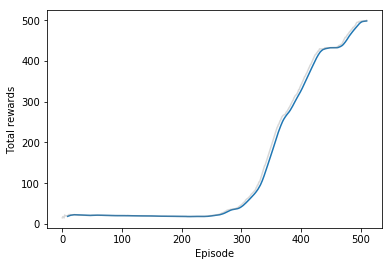

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

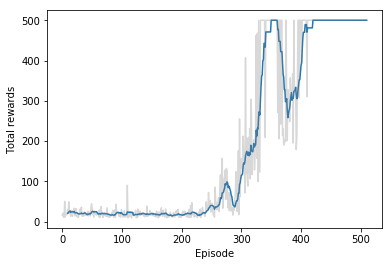

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

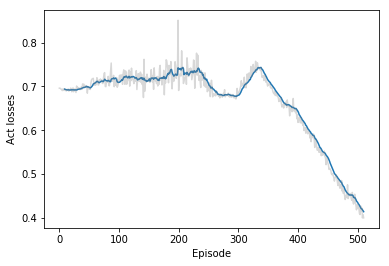

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

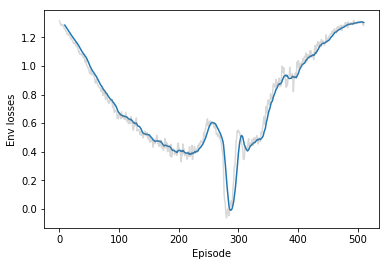

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

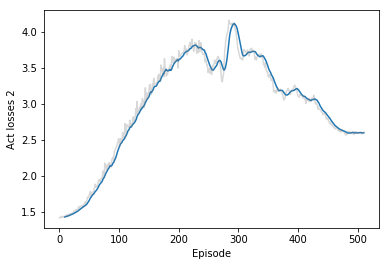

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
